In [88]:
from glob import glob

import pickle
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# ------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# ------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# ML Models for Hyperspectral Lithology Mapping

## Import Best Models

In [8]:
model_files = glob('../models/*.pkl')
model_files.sort()
model_files

['../models/DTree-SMOTE-kbest-71.43-fs.pkl',
 '../models/DTree-SMOTE-kbest-71.43.pkl',
 '../models/GBoost-SMOTE-rfc-71.43-fs.pkl',
 '../models/GBoost-SMOTE-rfc-71.43.pkl',
 '../models/GBoost-SMOTE-rfe-74.29-fs.pkl',
 '../models/GBoost-SMOTE-rfe-74.29.pkl',
 '../models/RForest-SMOTE-kbest-68.57-fs.pkl',
 '../models/RForest-SMOTE-kbest-68.57.pkl',
 '../models/RForest-SMOTE-rfc-68.57-fs.pkl',
 '../models/RForest-SMOTE-rfc-68.57.pkl']

In [26]:
# Identify Models and group corresponding files
model_names = ['-'.join(m.split('-')[:4]).replace('../models/', '').replace('.pkl', '') for m in model_files]
model_names = list(set(model_names))
model_names.sort()
model_names

['DTree-SMOTE-kbest-71.43',
 'GBoost-SMOTE-rfc-71.43',
 'GBoost-SMOTE-rfe-74.29',
 'RForest-SMOTE-kbest-68.57',
 'RForest-SMOTE-rfc-68.57']

## Import Study Area Dataset

In [6]:
points_df = pd.read_csv('../data/wip/prisma-l2d-standard-study-area.csv')
points_df.shape

(67048, 160)

In [9]:
points_df.columns

Index(['fid', '010', '011', '012', '013', '014', '015', '016', '017', '018',
       ...
       '214', '215', '216', '217', '218', '219', '220', '221', 'Latitude',
       'Longitude'],
      dtype='object', length=160)

## Filter Feature Columns

In [11]:
# Filter only the feature variables
features = points_df.drop(['fid', 'Latitude', 'Longitude'], axis=1)

## Scale the features

In [16]:
# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features.shape

(67048, 157)

## Predict Lithology Categories for the best models

In [45]:
predicted = {}

for mod in model_names:
    print(mod)

    model_file = f"../models/{mod}.pkl"
    fs_file = f"../models/{mod}-fs.pkl"

    fs_col = pickle.load(open(fs_file, 'rb'))
    model = pickle.load(open(model_file, 'rb'))

    # Apply Feature Selection to the data
    if type(fs_col) == RandomForestClassifier:
        rfc_df = pd.DataFrame({'feature':features.columns, 'importance':fs_col.feature_importances_})
        rfc_df = rfc_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
        rfc_cols = rfc_df.head(50).feature.tolist()
        index = [features.columns.get_loc(c) for c in rfc_cols if c in features]
        X_fs = scaled_features[:, index]
    else:
        X_fs = fs_col.transform(scaled_features)

    y_pred = model.predict(X_fs)

    predicted[mod] = pd.Series(y_pred)

DTree-SMOTE-kbest-71.43
GBoost-SMOTE-rfc-71.43
GBoost-SMOTE-rfe-74.29
RForest-SMOTE-kbest-68.57
RForest-SMOTE-rfc-68.57


In [61]:
pred_df = pd.DataFrame.from_dict(predicted)
print(pred_df.shape)
pred_df.head()

(67048, 5)


,DTree-SMOTE-kbest-71.43,GBoost-SMOTE-rfc-71.43,GBoost-SMOTE-rfe-74.29,RForest-SMOTE-kbest-68.57,RForest-SMOTE-rfc-68.57
0,Lm-Ml-Ft,Lm-Ml-Sl,Lm-Ml-Sl,Ml-Ps,Lm-Ml-Sl
1,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl
2,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Ft,Ml-Ps,Ml-Ps
3,Lm-Ml-Ft,Ml-Ps,Ml-Ps,Lm-Ml-Sl,Lm-Ml-Sl
4,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Sl,Ml-Ps,Ml-Ps


## Export Lithology Predictions

### Export CSV

In [56]:
lithology_df = points_df.join(pred_df).drop('fid', axis=1)
lithology_df.head()

,010,011,012,013,014,015,016,017,018,019,...,219,220,221,Latitude,Longitude,DTree-SMOTE-kbest-71.43,GBoost-SMOTE-rfc-71.43,GBoost-SMOTE-rfe-74.29,RForest-SMOTE-kbest-68.57,RForest-SMOTE-rfc-68.57
0,22019,21109,21422,21789,21601,21765,22021,22636,22257,20986,...,20377,23907,24374,32.317932,-7.860228,Lm-Ml-Ft,Lm-Ml-Sl,Lm-Ml-Sl,Ml-Ps,Lm-Ml-Sl
1,30160,28992,29384,29884,29687,30020,30373,31311,30730,29000,...,26892,31565,32205,32.317929,-7.859909,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl
2,22724,21714,21994,22184,22101,22258,22596,23141,22844,21550,...,21626,24990,25354,32.317664,-7.860550,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Ft,Ml-Ps,Ml-Ps
3,30914,29601,30015,30396,30025,30544,30963,31788,31356,29548,...,27768,32344,32923,32.317661,-7.860231,Lm-Ml-Ft,Ml-Ps,Ml-Ps,Lm-Ml-Sl,Lm-Ml-Sl
4,36690,35164,35444,36082,35634,36241,36482,37523,36902,34595,...,33024,38235,38851,32.317659,-7.859912,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Sl,Ml-Ps,Ml-Ps


In [58]:
lithology_cols = [
    'Latitude', 'Longitude', 'DTree-SMOTE-kbest-71.43',
    'GBoost-SMOTE-rfc-71.43', 'GBoost-SMOTE-rfe-74.29',
    'RForest-SMOTE-kbest-68.57', 'RForest-SMOTE-rfc-68.57'
]

In [59]:
lithology_df = lithology_df[lithology_cols]
lithology_df.head()

,Latitude,Longitude,DTree-SMOTE-kbest-71.43,GBoost-SMOTE-rfc-71.43,GBoost-SMOTE-rfe-74.29,RForest-SMOTE-kbest-68.57,RForest-SMOTE-rfc-68.57
0,32.317932,-7.860228,Lm-Ml-Ft,Lm-Ml-Sl,Lm-Ml-Sl,Ml-Ps,Lm-Ml-Sl
1,32.317929,-7.859909,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl
2,32.317664,-7.860550,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Ft,Ml-Ps,Ml-Ps
3,32.317661,-7.860231,Lm-Ml-Ft,Ml-Ps,Ml-Ps,Lm-Ml-Sl,Lm-Ml-Sl
4,32.317659,-7.859912,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Sl,Ml-Ps,Ml-Ps


In [62]:
lithology_df.to_csv('../data/out/hyperspectral-lithology-predictions-study-area.csv', index=False)

### Export Vector File

In [63]:
lithology_gdf = gpd.GeoDataFrame(lithology_df, geometry=gpd.points_from_xy(lithology_df['Longitude'], lithology_df['Latitude']))
lithology_gdf.head()

,Latitude,Longitude,DTree-SMOTE-kbest-71.43,GBoost-SMOTE-rfc-71.43,GBoost-SMOTE-rfe-74.29,RForest-SMOTE-kbest-68.57,RForest-SMOTE-rfc-68.57,geometry
0,32.317932,-7.860228,Lm-Ml-Ft,Lm-Ml-Sl,Lm-Ml-Sl,Ml-Ps,Lm-Ml-Sl,POINT (-7.86023 32.31793)
1,32.317929,-7.859909,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,Lm-Ml-Sl,POINT (-7.85991 32.31793)
2,32.317664,-7.860550,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Ft,Ml-Ps,Ml-Ps,POINT (-7.86055 32.31766)
3,32.317661,-7.860231,Lm-Ml-Ft,Ml-Ps,Ml-Ps,Lm-Ml-Sl,Lm-Ml-Sl,POINT (-7.86023 32.31766)
4,32.317659,-7.859912,Ml-Ps,Lm-Ml-Ft,Lm-Ml-Sl,Ml-Ps,Ml-Ps,POINT (-7.85991 32.31766)


In [65]:
# Apply CRS
lithology_gdf.geometry = lithology_gdf.geometry.set_crs("EPSG:4326")
lithology_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [66]:
lithology_gdf.to_file('../data/out/hyperspectral-lithology-predictions-study-area.gpkg', driver='GPKG')

## Lithology Maps

### GBoost-SMOTE-rfe-74.29

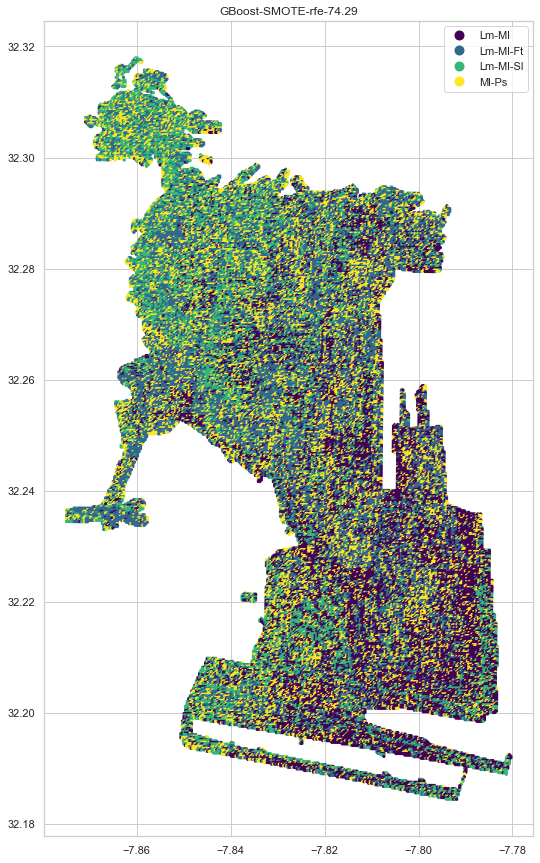

In [83]:
lithology_gdf.plot('GBoost-SMOTE-rfe-74.29', legend=True, categorical=True, cmap='viridis', markersize=5, figsize=(20, 15))
plt.title('GBoost-SMOTE-rfe-74.29')
plt.show()

### GBoost-SMOTE-rfc-71.43

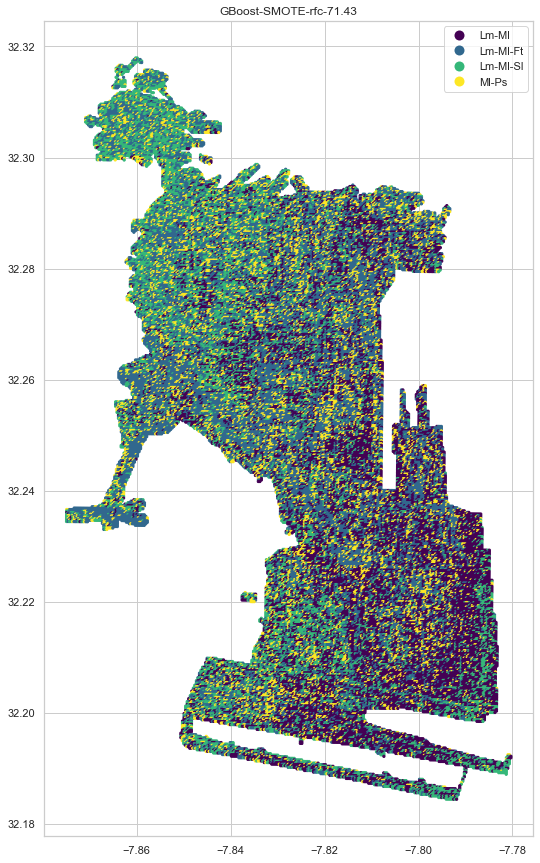

In [84]:
lithology_gdf.plot('GBoost-SMOTE-rfc-71.43', legend=True, categorical=True, cmap='viridis', markersize=5, figsize=(20, 15))
plt.title('GBoost-SMOTE-rfc-71.43')
plt.show()

### DTree-SMOTE-kbest-71.43

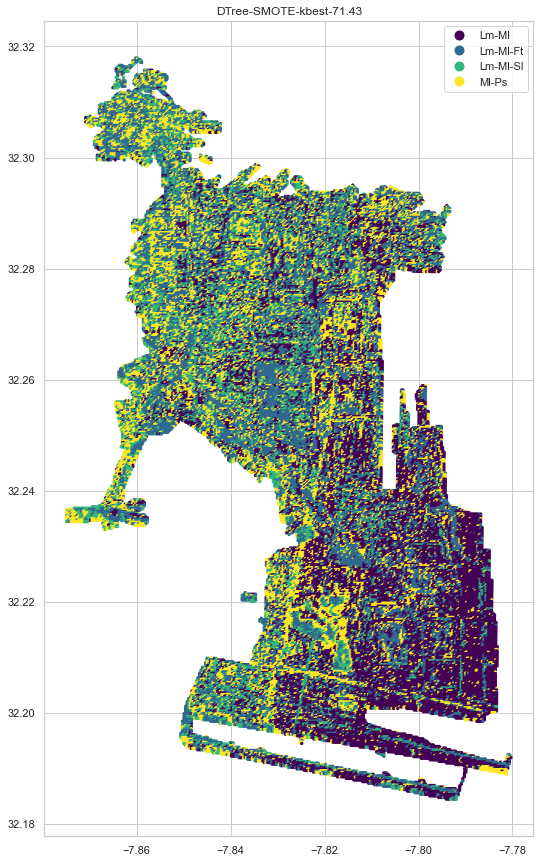

In [85]:
lithology_gdf.plot('DTree-SMOTE-kbest-71.43', legend=True, categorical=True, cmap='viridis', markersize=5, figsize=(20, 15))
plt.title('DTree-SMOTE-kbest-71.43')
plt.show()

### RForest-SMOTE-rfc-68.57

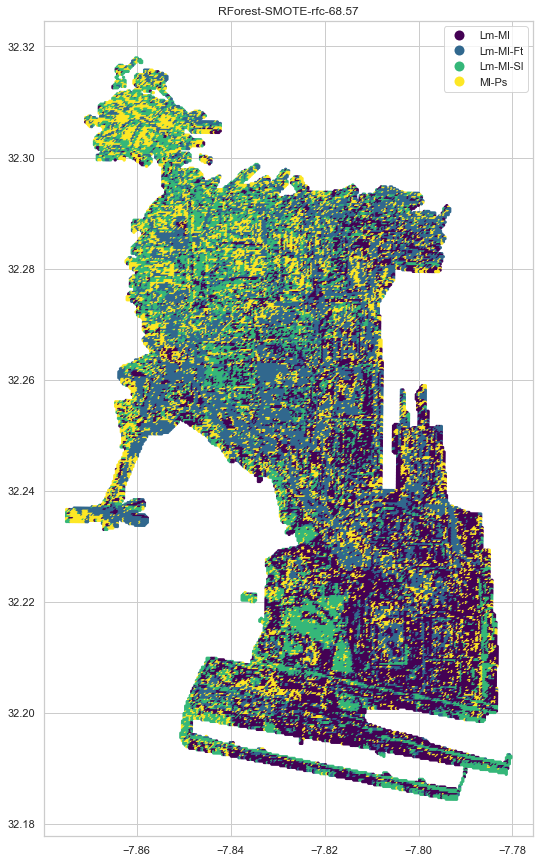

In [86]:
lithology_gdf.plot('RForest-SMOTE-rfc-68.57', legend=True, categorical=True, cmap='viridis', markersize=5, figsize=(20, 15))
plt.title('RForest-SMOTE-rfc-68.57')
plt.show()

### RForest-SMOTE-kbest-68.57

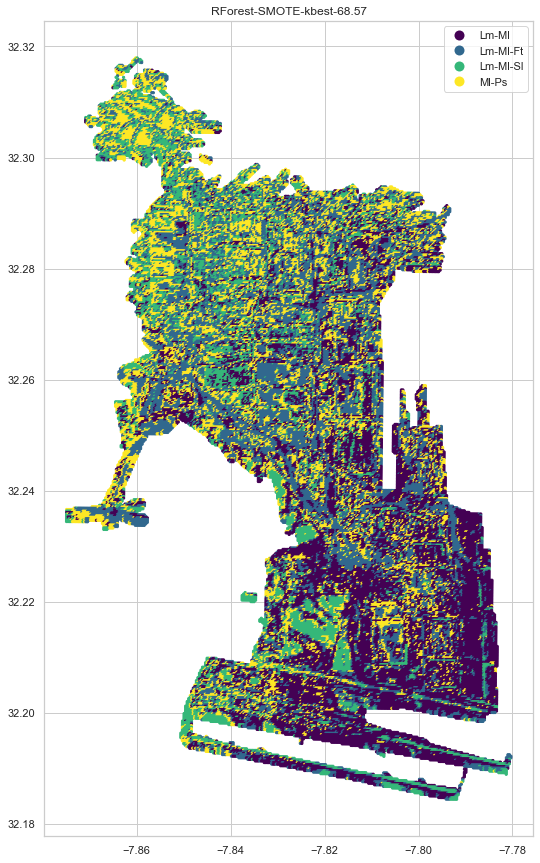

In [87]:
lithology_gdf.plot('RForest-SMOTE-kbest-68.57', legend=True, categorical=True, cmap='viridis', markersize=5, figsize=(20, 15))
plt.title('RForest-SMOTE-kbest-68.57')
plt.show()